### ATTENTION MECHANISM

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import load_model


In [39]:
# Hiperparámetros
batch_size = 32
lr = 1e-3
epochs = 10
kr = 1e-4  # Regularización L1
drop_prec = 0.25  # Dropout

In [40]:
# Cargar y procesar los datos
df_train = pd.read_parquet('../data/processed/df_train_reduced.parquet')
df_onehot = tf.keras.utils.to_categorical(df_train)
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)


In [41]:

# Dimensiones de entrada
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
input_shape = (feature_size, inChannel)

# Codificador con atención
inputs = Input(shape=input_shape)

In [42]:
# Capas convolucionales del encoder
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)
x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)

# Mecanismo de atención
def attention_1d(inputs):
    # Capa densa para generar los pesos de atención
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    # Multiplicar las activaciones convolucionales por los pesos de atención
    attention = Multiply()([inputs, attention])
    return attention

# Aplicar la atención después del codificador
x = attention_1d(x)

In [43]:
# Decodificador convolucional
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
outputs = Conv1D(inChannel, 5, activation='softmax', padding='same')(x)


In [44]:
# Definir el modelo
attention_model = Model(inputs, outputs)

In [45]:
# Compilar el modelo
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
attention_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1000, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1000, 32)  │        512 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 500, 32)   │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 500, 32)   │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 500, 64)   │     10,304 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 250, 64)   │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 250, 64)   │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 250, 128)  │     41,088 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 250, 128)  │     16,512 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 250, 128)  │          0 │ conv1d_14[0][0],  │
│ (Multiply)          │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 250, 64)   │     41,024 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_4     │ (None, 500, 64)   │          0 │ conv1d_15[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 500, 32)   │     10,272 │ up_sampling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_5     │ (None, 1000, 32)  │          0 │ conv1d_16[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 1000, 3)   │        483 │ up_sampling1d_5[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,195 (469.51 KB)

 Trainable params: 120,195 (469.51 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:

# Definir DataGenerator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            self.x_missing[i, missing_index, :] = [1, 0, 0]

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [47]:

# Entrenamiento
train_generator = DataGenerator(batch_size=batch_size, x_dataset=train_X, missing_perc=0.1)
valid_generator = DataGenerator(batch_size=batch_size, x_dataset=valid_X, missing_perc=0.1)


In [ ]:
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [48]:
attention_model_train = attention_model.fit(
    x=train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator,
    callbacks= [EarlyStopping]
    
)

Epoch 1/10
 1/87 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.5003 - loss: 1.5415

/Users/celiacabello/miniconda3/envs/TFM/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5752 - loss: 1.1374 - val_accuracy: 0.8656 - val_loss: 0.4265
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8744 - loss: 0.3972 - val_accuracy: 0.9045 - val_loss: 0.3134
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8975 - loss: 0.3210 - val_accuracy: 0.9055 - val_loss: 0.2865
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9015 - loss: 0.2921 - val_accuracy: 0.9113 - val_loss: 0.2643
Epoch 5/10
 5/87 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9036 - loss: 0.2790

### plotting

/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_18587/68356141.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")


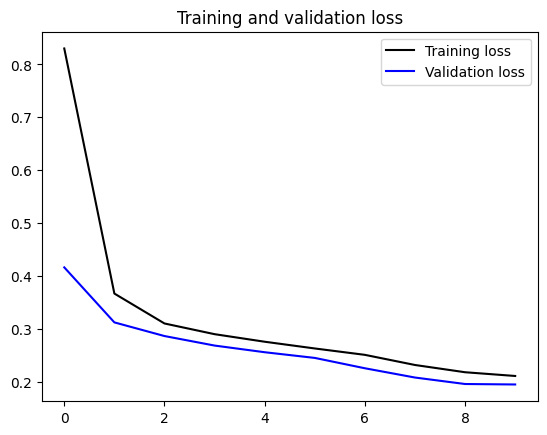

In [ ]:
# plot loss curve on validation data
loss = attention_model_train.history['loss']
val_loss = attention_model_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_18587/3295592865.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_18587/3295592865.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")


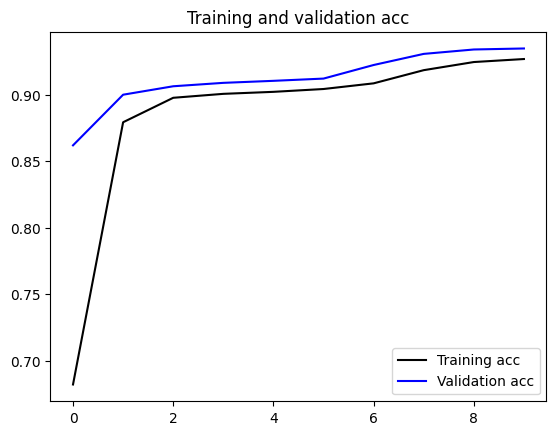

In [ ]:
# function modified -- key "acc" did not exist. the correct key is 
# plot accuracy curve on validation data
print(attention_model_train.history.keys())
acc = attention_model_train.history['accuracy'] #initially the key was acc
val_acc = attention_model_train.history['val_accuracy']#initially the key was val_ acc
plt.figure()
plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")
plt.title('Training and validation acc')
plt.legend()
plt.show()

In [ ]:
print("Final Training Loss:", loss[-1])
print("Final Validation Loss:", val_loss[-1])
print("Final Training Accuracy:", acc[-1])
print("Final Validation Accuracy:", val_acc[-1])

Final Training Loss: 0.210826113820076
Final Validation Loss: 0.19474731385707855
Final Training Accuracy: 0.9268530607223511
Final Validation Accuracy: 0.9347842335700989


### TESTING

In [ ]:
df_test = pd.read_parquet('../data/processed/df_test_reduced.parquet')
test_X = to_categorical(df_test)
test_X.shape

(877, 1000, 3)

#### Prediction on test data

In [ ]:
import numpy as np

# Porcentajes de pérdida
missing_perc_list = [0.1, 0.2, 0.3, 0.4]

# Función para calcular la probabilidad de los genotipos 0, 1, 2
def cal_prob(predict_missing_onehot):
    predict_prob = predict_missing_onehot[:,:,1:3] / predict_missing_onehot[:,:,1:3].sum(axis=2, keepdims=True)
    return predict_prob

# Diccionario para almacenar los resultados de precisión por cada porcentaje
accuracy_summary = {}

# Iterar sobre los porcentajes de datos faltantes
for missing_perc in missing_perc_list:
    avg_accuracy = []
    
    # Generar índices faltantes de una vez para todas las muestras
    num_samples = test_X.shape[0]
    missing_indices = [np.random.randint(test_X.shape[1], size=int(missing_perc * test_X.shape[1])) for _ in range(num_samples)]
    
    # Generar la matriz con datos faltantes en un solo paso
    test_X_missing = test_X.copy()
    for i in range(num_samples):
        test_X_missing[i, missing_indices[i], :] = [1, 0, 0]  # Generar genotipos faltantes
    
    # Predecir utilizando el modelo entrenado en lotes en lugar de predicciones individuales
    predict_onehot = attention_model.predict(test_X_missing, batch_size=32)  # Ajustar el tamaño del batch si es necesario
    
    # Iterar sobre cada muestra para calcular las precisiones
    for i in range(num_samples):
        # Solo se consideran las posiciones faltantes
        predict_missing_onehot = predict_onehot[i:i + 1, missing_indices[i], :]
        
        # Predicción de la etiqueta
        predict_missing = np.argmax(predict_missing_onehot, axis=2)

        # Etiqueta real
        label_missing_onehot = test_X[i:i + 1, missing_indices[i], :]
        label_missing = np.argmax(label_missing_onehot, axis=2)

        # Calcular la precisión
        correct_prediction = np.equal(predict_missing, label_missing)
        accuracy = np.mean(correct_prediction)
        avg_accuracy.append(accuracy)

    # Guardar la precisión promedio para el porcentaje actual
    accuracy_summary[missing_perc] = np.mean(avg_accuracy)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
# Mostrar el resumen de las precisiones promedio
print("\n=== Resumen de precisión promedio por porcentaje de pérdida ===")
for perc, acc in accuracy_summary.items():
    print(f'Porcentaje de pérdida: {perc * 100}%, Precisión promedio: {acc:.4f}')


=== Resumen de precisión promedio por porcentaje de pérdida ===
Porcentaje de pérdida: 10.0%, Precisión promedio: 0.8370
Porcentaje de pérdida: 20.0%, Precisión promedio: 0.8355
Porcentaje de pérdida: 30.0%, Precisión promedio: 0.8310
Porcentaje de pérdida: 40.0%, Precisión promedio: 0.8295
